<table width="100%" style="border: none; border-collapse: collapse;">
  <tr>
    <td align="left" width="10%" style="border: none;">
      <img src="logocimat.png" width="120">
    </td>
    <td align="center" width="55%" style="border: none;">
      <h2>Centro de Investigación en Matemáticas, A.C.</h2>
    </td>
    <td align="right" width="25%" style="border: none;">
      <img src="logo_secihti.png" width="350">
    </td>
  </tr>
</table>

<p align="center">
  <img src="logo_insp.png" alt="Logo" width="250"/>
</p>

<h3 align="center">Evaluación de diferentes umbrales para la asignación de la categoría 'Sin etiqueta' en las imagenes 100% etiquetadas</h3>

<h4 align="center">Autor: Sarahi Ventura Angoa</h4>

<p align="center">Maestría en Cómputo Estadístico - CIMAT Mty</p>
<p align="center">Junio 2025</p>


<div class="alert alert-block alert-warning">

<b>🎯 Estrategia 5: Asignación de la categoría "Sin etiqueta" basada en "probabilidad máxima < umbral"  </b><br><br>

Esta estrategia considera que el modelo está inseguro si <b>la probabilidad máxima es baja</b>.<br><br>
  <ul>
    <li>Se definió un umbral de <code>0.3</code> para la probabilidad máxima (<code>1_proba_max</code>).</li>
  </ul>
Para manetener equilibrio entre el orcentaje de asignaciones como "Sin etiqueta" <code>10</code> ("Sin etiqueta").<br><br>
</div>

<div class="alert alert-block alert-success">
<b>Importacion de las librerias</b></div>


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-block alert-success">
  <b>📁 Rutas de los archivos .csv utilizados en la evaluación</b><br><br>
  • <code>Caract_paralelo_{nombre_imagen}.csv</code>: Contiene la predicción por superpíxel realizada por el modelo previamente entrenado.<br>
  • <code>Etiquetado_{nombre_imagen}.csv</code>: Contiene la etiqueta asignada manualmente a cada superpíxel (etiquetado de referencia o "ground truth").
</div>



In [2]:
# Rutas

# Carpeta donde están las img de prueba y los archivos Etiquetado_ .csv y el .tif
ruta_carpeta_imagenes = "C:/Users/DELL/Documents/tesis/tesis_visual_code/Imagenes_prueba_etiquetadas_100"  # Carpeta donde están las img de prueba y los archivos Etiquetado_ .csv y el .tif

# Carpeta donde están los archivos Caract_paralelo y los .tif  
ruta_salida_csv = "C:/Users/DELL/Documents/tesis/tesis_visual_code/estrrategias_asignacion_sin_etiqueta"  # Carpeta donde se guardaran los .csv predichos por el modelo y los .tif Caract_paralelo_


In [3]:
print("\n Archivos en la carpeta de IMÁGENES / ETIQUETAS MANUALES:")
for f in sorted(os.listdir(ruta_carpeta_imagenes)):
    if f.lower().endswith(".csv"):
        print(f" - {f}")
print("\n Archivos en la carpeta de PREDICCIONES DEL MODELO:")
for f in sorted(os.listdir(ruta_salida_csv)):
    if f.lower().endswith(".csv"):
        print(f" - {f}")


 Archivos en la carpeta de IMÁGENES / ETIQUETAS MANUALES:
 - Etiquetado_image_x5_1272.csv
 - Etiquetado_image_x5_163.csv
 - Etiquetado_image_x5_164.csv
 - Etiquetado_image_x5_172.csv
 - Etiquetado_image_x5_1730.csv
 - Etiquetado_image_x5_174.csv
 - Etiquetado_image_x5_176.csv
 - Etiquetado_image_x5_1797.csv
 - Etiquetado_image_x5_181.csv
 - Etiquetado_image_x5_201.csv
 - Etiquetado_image_x5_221.csv
 - Etiquetado_image_x5_2448.csv
 - Etiquetado_image_x5_2471.csv
 - Etiquetado_image_x5_2486.csv
 - Etiquetado_image_x5_250.csv
 - Etiquetado_image_x5_2502.csv
 - Etiquetado_image_x5_2868.csv
 - Etiquetado_image_x5_2983.csv
 - Etiquetado_image_x5_3378.csv
 - Etiquetado_image_x5_3425.csv
 - Etiquetado_image_x5_3628.csv
 - Etiquetado_image_x5_3913.csv
 - Etiquetado_image_x5_4037.csv
 - Etiquetado_image_x5_627.csv

 Archivos en la carpeta de PREDICCIONES DEL MODELO:
 - Caract_paralelo_image_x5_1272.csv
 - Caract_paralelo_image_x5_163.csv
 - Caract_paralelo_image_x5_164.csv
 - Caract_paralelo_im

In [4]:
# --------------------------------------------
#  Diccionario de categorías con sus nombres
# --------------------------------------------
categorias = {
    0:  "Árbol",
    1:  "Suelo desnudo",
    2:  "Pavimento",
    3:  "Cuerpo de agua",
    4:  "Techo de lámina",
    5:  "Techo de losa",
    6:  "Arbusto",
    7:  "Hierba y pasto seco",
    8:  "Hierba y pasto verde",
    9:  "Sombra",
    10: "Sin etiqueta"   # Se asigna cuando el modelo está incierto
}

In [5]:
# ============================================
# UNIR TODAS LAS IMÁGENES EN UN SOLO DATAFRAME
# ============================================

# Obtener todos los archivos Caract_paralelo
archivos_caract = [f for f in os.listdir(ruta_salida_csv) if f.startswith("Caract_paralelo") and f.endswith(".csv")]

import pandas as pd
import os

# Lista donde vamos a guardar los datos de TODAS las imágenes
datos_todas_imagenes = []

for archivo_caract in archivos_caract:
    # -----------------------------------------
    # Obtener nombre base de la imagen
    # -----------------------------------------
    nombre_imagen = archivo_caract.replace("Caract_paralelo_", "").replace(".csv", "")
    archivo_etiquetado_manualmente = f"Etiquetado_{nombre_imagen}.csv"
    ruta_completa_etiquetado = os.path.join(ruta_carpeta_imagenes, archivo_etiquetado_manualmente)

    # -----------------------------------------
    # Verificar que existe el archivo de etiquetado manual
    # -----------------------------------------
    if not os.path.exists(ruta_completa_etiquetado):
        print(f"  Archivo no encontrado: {archivo_etiquetado_manualmente}. Saltando...")
        continue

    # -----------------------------------------
    # Columnas de interes del archivo de Caract_paralelo
    # -----------------------------------------
    df_caract = pd.read_csv(
        os.path.join(ruta_salida_csv, archivo_caract),
        usecols=["indice", "prediction", "1_proba_max", "2_proba_max",
                "3_proba_max", "4_proba_max", "5_proba_max", "6_proba_max",
                "7_proba_max", "8_proba_max", "9_proba_max", "10_proba_max","dif_1ra_2da_prob", "dif_1ra_3ra_prob"]
    )

    # -----------------------------------------
    # Columnas de interes del archivo de Etiquetado_
    # -----------------------------------------
    df_etiquetado = pd.read_csv(
        ruta_completa_etiquetado,
        usecols=["indice", "categoria"]
    )

    # -----------------------------------------
    # Unir por indice
    # -----------------------------------------
    df_comparacion = df_etiquetado.merge(
        df_caract,
        on="indice",
        how="left"
    )

    # -----------------------------------------
    # Agregar columna de nombre de imagen
    # -----------------------------------------
    df_comparacion["imagen"] = nombre_imagen

    # -----------------------------------------
    # Guardar en la lista general
    # -----------------------------------------
    datos_todas_imagenes.append(df_comparacion[["imagen", "indice", "categoria",     
                                                "prediction", "1_proba_max", "2_proba_max",
                                                "3_proba_max", "4_proba_max", "5_proba_max", "6_proba_max",
                                                "7_proba_max", "8_proba_max", "9_proba_max", "10_proba_max",
                                                "dif_1ra_2da_prob", "dif_1ra_3ra_prob"]])

# ============================================
# Concatenar TODAS las imágenes en UN SOLO DataFrame
# ============================================
df_completo_etiquetado_predicciones_original = pd.concat(datos_todas_imagenes, ignore_index=True)

print("\n DataFrame UNIDO con la infromacion de todas las images")
print(df_completo_etiquetado_predicciones_original.head())
print(f"Total de superpíxeles en TODO el dataset: {len(df_completo_etiquetado_predicciones_original)}")



 DataFrame UNIDO con la infromacion de todas las images
          imagen  indice  categoria  prediction  1_proba_max  2_proba_max  \
0  image_x5_1272    45.0        5.0           4     0.506763     0.165645   
1  image_x5_1272     6.0        5.0           4     0.378005     0.218029   
2  image_x5_1272     7.0        5.0           2     0.354175     0.310305   
3  image_x5_1272    67.0        5.0           4     0.448126     0.190227   
4  image_x5_1272     8.0        5.0           4     0.318171     0.251115   

   3_proba_max  4_proba_max  5_proba_max  6_proba_max  7_proba_max  \
0     0.149438     0.085669     0.039091     0.020000     0.015939   
1     0.170916     0.080050     0.058768     0.049351     0.022500   
2     0.240238     0.056949     0.021667     0.016667     0.000000   
3     0.130289     0.091896     0.072869     0.021538     0.020952   
4     0.197045     0.078524     0.056190     0.051714     0.033372   

   8_proba_max  9_proba_max  10_proba_max  dif_1ra_2da_prob

<div class="alert alert-block alert-info">
<stong>Función para medir el desempeño por modelo para cada umbral, para cada clase y de forma global</strong><br>

<ul>
    <li>Aqui cada fila representa las instancias reales de una clase específica <i>clase verdadera </i> según el etiquetado manual </li>
    <li>cada columna indica cuántas veces el modelo predijo esa clase <i>prediction</i> </li>
</ul>
</div>

In [6]:
def calcular_metricas_clases_con_resumen(df,
                                         col_real="categoria",
                                         col_pred="pred_estrat_5",
                                         categorias=None,
                                         clase_sin_etiqueta=10,
                                         incluir_sin_etiqueta=False):
    metricas = []
    clases = sorted(set(df[col_real].unique()) | set(df[col_pred].unique()))
    total_soporte = len(df)

    TP_total, FP_total, FN_total = 0, 0, 0

    for clase in clases:
        # nombre de la clase
        nombre = categorias.get(clase, f"Clase_{clase}") if categorias else f"Clase_{clase}"

        # True positives: predicción correcta, tanto la clase real como la predicha son iguales
        TP = ((df[col_real] == clase) & (df[col_pred] == clase)).sum()
        # Falses positives (FP): el modelo predijo esta clase, pero en realidad era otra (errores a lo largo de la columna i)
        FP = ((df[col_real] != clase) & (df[col_pred] == clase)).sum()
        # Falses negatives (FN): la instancia era realmente de esta clase, pero el modelo predijo otra (errores a lo largo de la fila j)
        FN = ((df[col_real] == clase) & (df[col_pred] != clase)).sum()
        # True negatives (TN): todas las instancias que no eran ni reales ni predichas como esta clase
        TN = ((df[col_real] != clase) & (df[col_pred] != clase)).sum()

        # Soporte: número de veces que esta clase aparece como verdadera (frecuencia real)
        soporte = (df[col_real] == clase).sum()
        # Peso relativo de esta clase (w_i), basado en su proporción del total
        peso = soporte / total_soporte if total_soporte > 0 else 0

        # -------------------------------------------------------------------------------------
        # Calculo de las métricas Accuracy, Presicion, Recall y F1-score 
        # ------------------------------------------------------------------------------------ 
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        TP_total += TP
        FP_total += FP
        FN_total += FN

        metricas.append({
            "Clase": nombre,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "Soporte": soporte,
            "Peso w_i": peso,
            "Accuracy": accuracy,
            "Precisión": precision,
            "Recall": recall,
            "F1-score": f1,
            "w_i * Precisión": peso * precision,
            "w_i * Recall": peso * recall,
            "w_i * F1": peso * f1
        })

    df_metricas = pd.DataFrame(metricas)

    # Filtrar clase "Sin etiqueta" si no se quiere incluir
    if not incluir_sin_etiqueta and categorias:
        nombre_sin = categorias.get(clase_sin_etiqueta, "Sin etiqueta")
        df_filtrado = df_metricas[df_metricas["Clase"] != nombre_sin]
    else:
        df_filtrado = df_metricas

    # -------------------------------------------------------------------------------------
    # Calcular Macro-average y Weighted-average y Micro-average
    # ------------------------------------------------------------------------------------

    macro_precision = df_filtrado["Precisión"].mean()
    macro_recall = df_filtrado["Recall"].mean()
    macro_f1 = df_filtrado["F1-score"].mean()

    weighted_precision = df_filtrado["w_i * Precisión"].sum()
    weighted_recall = df_filtrado["w_i * Recall"].sum()
    weighted_f1 = df_filtrado["w_i * F1"].sum()

    precision_micro = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0.0
    recall_micro = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0.0
    f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro) if (precision_micro + recall_micro) > 0 else 0.0

    metricas_globales = {
        "Precision_weighted": weighted_precision,
        "Recall_weighted": weighted_recall,
        "F1_weighted": weighted_f1,
        "Precision_macro": macro_precision,
        "Recall_macro": macro_recall,
        "F1_macro": macro_f1,
        "Precision_micro": precision_micro,
        "Recall_micro": recall_micro,
        "F1_micro": f1_micro
    }

    return df_metricas, metricas_globales


<div class="alert alert-block alert-success">
  <b>📈 Histogramas de frecuencia absolutas de La probabilidad más alta </b> <br>
  Este gráfico permiten visualizar en qué rangos se concentran los casos más ambiguos y establecer el umbral adecuado, para establecer el hasta donde puede caer elumbral, y cuantos casos paroximadamente serían considerados como "Sin etiqueta"
  <ul>
    <li>En el eje X se muestran los intervalos (bins) de la variable todas_dif_1ra_3ra. </li>
    <li> En el eje Y se muestra cuántos valores caen en cada intervalo (frecuencia absolua)</li>
  </ul>
</div>


In [7]:
# Copiar el DataFrame original
df_estrat_5 = df_completo_etiquetado_predicciones_original.copy()
df_estrat_5["pred_estrat_5"] = df_estrat_5["prediction"]

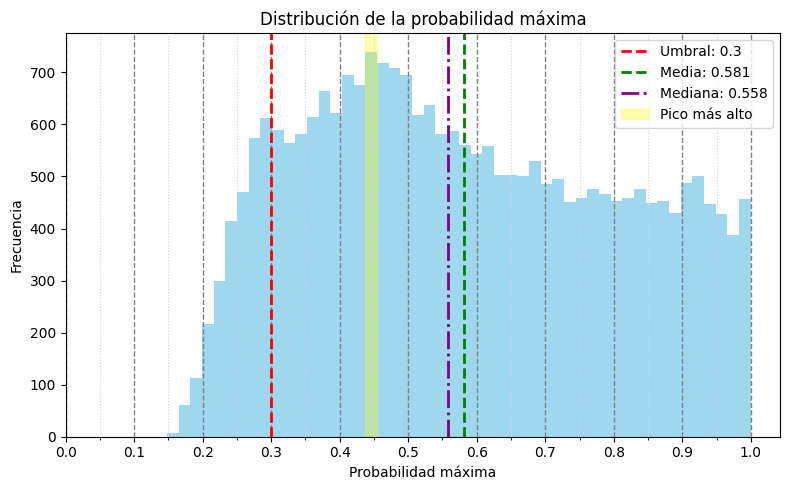

In [8]:
# ---------------------------------------
# Parámetros
# ---------------------------------------
umbral_max = 0.3
proba = df_estrat_5["1_proba_max"]

# ---------------------------------------
# Estadísticas
# ---------------------------------------
media_prob_max = np.mean(proba)
mediana_prob_max = np.median(proba)

counts, bin_edges = np.histogram(proba, bins=50)
pico_inicio = bin_edges[np.argmax(counts)]
pico_fin = bin_edges[np.argmax(counts) + 1]

minimo = np.min(proba)
maximo = np.max(proba)

# ---------------------------------------
# Gráfico
# ---------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(proba, bins=50, color='skyblue', alpha=0.8)

# Líneas verticales y zona del pico
ax.axvline(umbral_max, color='red', linestyle='--', linewidth=2, label=f"Umbral: {umbral_max}")
ax.axvline(media_prob_max, color='green', linestyle='--', linewidth=2, label=f"Media: {media_prob_max:.3f}")
ax.axvline(mediana_prob_max, color='purple', linestyle='-.', linewidth=2, label=f"Mediana: {mediana_prob_max:.3f}")
ax.axvspan(pico_inicio, pico_fin, color='yellow', alpha=0.3, label="Pico más alto")

# Rejilla
ticks_major = np.linspace(0, 1, 11)
ticks_minor = np.linspace(0, 1, 21)
ax.set_xticks(ticks_major)
ax.set_xticks(ticks_minor, minor=True)
ax.grid(which='major', axis='x', color='gray', linestyle='--', linewidth=1.0)
ax.grid(which='minor', axis='x', color='lightgray', linestyle=':', linewidth=0.8)

# Estética
ax.set_title("Distribución de la probabilidad máxima")
ax.set_xlabel("Probabilidad máxima")
ax.set_ylabel("Frecuencia")
ax.legend()

plt.tight_layout()
plt.show()


In [9]:
# Aplicar la lógica de la estrategia 5
umbral_max_proba = 0.3

# Asignar categoría 10 si la probabilidad máxima es menor al umbral
df_estrat_5.loc[df_estrat_5["1_proba_max"] < umbral_max_proba, "pred_estrat_5"] = 10

# ----------------------------------------------------
# Contar cuántos superpíxeles quedaron "Sin etiqueta"
# ----------------------------------------------------
total_superpixeles_global = len(df_estrat_5) 
total_sin_etiqueta = (df_estrat_5["pred_estrat_5"] == 10).sum()
porcentaje_sin_etiqueta = 100 * total_sin_etiqueta / total_superpixeles_global

print(f"\n Superpíxeles 'Sin etiqueta' (estrategia 5): {total_sin_etiqueta} de {total_superpixeles_global} ({porcentaje_sin_etiqueta:.2f}%)")

# ------------------------------------------------------------
# Calcular métricas por clase y globales para estrategia 5
# ------------------------------------------------------------
df_clase_estrat_5, metricas_globales_estrat_5 = calcular_metricas_clases_con_resumen(
    df_estrat_5,
    col_real="categoria",
    col_pred="pred_estrat_5",
    categorias=categorias,
    clase_sin_etiqueta=10,
    incluir_sin_etiqueta=True
)

# Imprimir tabla de métricas por clase
print("\n Métricas por clase (Estrategia 5):\n")
print(df_clase_estrat_5[[  
    "Clase", "TP", "FP", "FN", "Soporte", "Peso w_i",
    "Accuracy", "Precisión", "Recall", "F1-score",
    "w_i * Precisión", "w_i * Recall", "w_i * F1"
]].round(4).to_string(index=False))

# Imprimir métricas globales
print("\n Métricas globales (Estrategia 5):")
for clave, valor in metricas_globales_estrat_5.items():
    print(f"{clave}: {valor:.4f}")


 Superpíxeles 'Sin etiqueta' (estrategia 5): 2722 de 25016 (10.88%)

 Métricas por clase (Estrategia 5):

               Clase   TP   FP   FN  Soporte  Peso w_i  Accuracy  Precisión  Recall  F1-score  w_i * Precisión  w_i * Recall  w_i * F1
               Árbol 1979 4723  362     2341    0.0936    0.7967     0.2953  0.8454    0.4377           0.0276        0.0791    0.0410
       Suelo desnudo 1627 1510 1184     2811    0.1124    0.8923     0.5186  0.5788    0.5471           0.0583        0.0650    0.0615
           Pavimento  846  600  978     1824    0.0729    0.9369     0.5851  0.4638    0.5174           0.0427        0.0338    0.0377
      Cuerpo de agua  339   19  290      629    0.0251    0.9876     0.9469  0.5390    0.6869           0.0238        0.0136    0.0173
     Techo de lámina 3396 1491  318     3714    0.1485    0.9277     0.6949  0.9144    0.7897           0.1032        0.1358    0.1172
       Techo de losa  506  523 1227     1733    0.0693    0.9300     0.4917  0.2920

<div class="alert alert-info">
<p>
El análisis detallado de desempeño (incluyendo métricas como precisión general, precisión por categoría, reporte de errores y matrices de confusión) se realiza en un notebook complementario llamado:
</p>

<p>
<b><code>funcion_medir_desempeño_modelo_considerando_sin_etiqueta_estrategia_5.ipynb</code></b>
</p>

<strong>Aplicación y visualización</strong><br><br>

<p>
En esta parte se carga el archivo con las predicciones del modelo para cada una de las imágenes seleccionadas.
Se aplica la siguiente regla para identificar predicciones con alta incertidumbre:
</p>

<code>
  Si probabilidad más alta &lt; 0.3 → "Sin etiqueta" (10)
</code><br><br>

<p>
Se crea una nueva columna <code>prediction_actual_estrategia5</code>, actualizando aquellas predicciones donde la probabilidad maxima a es menor al umbral.
Además, se cuenta cuántos superpíxeles fueron reasignados como "Sin etiqueta".
</p>

<p>
Finalmente, se visualiza cada imagen con los colores correspondientes a las nuevas etiquetas generadas por esta estrategia.
</p>

</div>


<div class="alert alert-block alert-success">
  <strong> Ruta de las imagenes para evaluar el desempeño</strong><br>
</div>

In [10]:
import os
import pandas as pd
from funciones_auxiliares_predicciones import seg_SLIC

# ----------------------------------------------------
# Configuración de rutas
# ----------------------------------------------------
#ruta_img_evaluar_desempeño 
ruta_predicciones_csv = r"C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias"


In [11]:

# Listar archivos JPG
imagenes_jpg = [f for f in os.listdir(ruta_predicciones_csv) if f.lower().endswith('.jpg')]

# Mostrar la lista
print("\n Imágenes .jpg encontradas en la carpeta:")
for img in imagenes_jpg:
    print("-", img)

print(f"\n Total de imágenes .jpg: {len(imagenes_jpg)}")



 Imágenes .jpg encontradas en la carpeta:
- image_x5_1272.jpg
- image_x5_1730.jpg
- image_x5_250.jpg

 Total de imágenes .jpg: 3


In [12]:
# ----------------------------------------------------
# Parámetros de segmentación
# ----------------------------------------------------
tamano_superpixeles = 40
ruler = 10
iteraciones = 10
tamano_minimo = 20

# ----------------------------------------------------
# Umbrales de Estrategia 5
# ----------------------------------------------------
umbral_proba_max_estrat_5 = 0.3

# ----------------------------------------------------
# Procesar todas las imágenes en la carpeta
# ----------------------------------------------------
imagenes_jpg = [f for f in os.listdir(ruta_predicciones_csv) if f.lower().endswith('.jpg')]

for imagen in imagenes_jpg:
    nombre_base = os.path.splitext(imagen)[0]
    print(f"\n===============================")
    print(f" Procesando imagen: {imagen}")
    print(f"===============================\n")
    
    # Segmentación SLIC
    path_imagen_completa = os.path.join(ruta_predicciones_csv, imagen)
    img_seg, Labels_slic, number_slic = seg_SLIC(
        path_image=path_imagen_completa,
        parametro_1=tamano_superpixeles,
        parametro_2=ruler,
        parametro_3=iteraciones,
        parametro_4=tamano_minimo
    )
    
    # Cargar CSV de predicciones
    nombre_csv = f"Caract_paralelo_{nombre_base}.csv"
    ruta_csv_completa = os.path.join(ruta_predicciones_csv, nombre_csv)
    
    if not os.path.exists(ruta_csv_completa):
        print(f" CSV no encontrado: {nombre_csv}. Saltando...")
        continue
    
    df_image_pred = pd.read_csv(ruta_csv_completa)

    # Aplicar Estrategia 5
    df_image_pred["prediction_actual_estrategia5"] = df_image_pred["prediction"]

    condicion1 = df_image_pred["1_proba_max"] < umbral_proba_max_estrat_5

    df_image_pred.loc[
        condicion1,
        "prediction_actual_estrategia5"
    ] = 10  # Asignar 'Sin etiqueta'
    
    # Contar cuántos superpíxeles fueron marcados como 'Sin etiqueta'
    num_cambiados = (df_image_pred["prediction_actual_estrategia5"] == 10).sum()
    print(f"   Superpíxeles marcados como 'Sin etiqueta': {num_cambiados}")
    
    # Guardar CSV actualizado
    ruta_csv_salida = os.path.join(ruta_predicciones_csv, f"Caract_paralelo_{nombre_base}_con_estrategia5.csv")
    df_image_pred.to_csv(ruta_csv_salida, index=False)
    print(f"   Nuevo CSV guardado en: {ruta_csv_salida}")



 Procesando imagen: image_x5_1272.jpg

   Superpíxeles marcados como 'Sin etiqueta': 255
   Nuevo CSV guardado en: C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias\Caract_paralelo_image_x5_1272_con_estrategia5.csv

 Procesando imagen: image_x5_1730.jpg

   Superpíxeles marcados como 'Sin etiqueta': 59
   Nuevo CSV guardado en: C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias\Caract_paralelo_image_x5_1730_con_estrategia5.csv

 Procesando imagen: image_x5_250.jpg

   Superpíxeles marcados como 'Sin etiqueta': 109
   Nuevo CSV guardado en: C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias\Caract_paralelo_image_x5_250_con_estrategia5.csv


<div class="alert alert-block alert-success">
  <strong> VISUALIZACIÓN DE LA IMAGENES CON LAS NUEVAS PREDICCIONES</strong><br>
</div>


 Procesando y pintando imagen: image_x5_1272.jpg



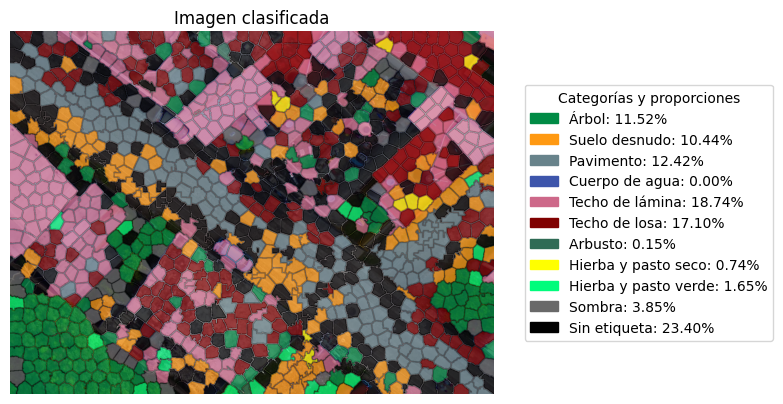

 Imagen pintada exitosamente: image_x5_1272.jpg

 Procesando y pintando imagen: image_x5_1730.jpg



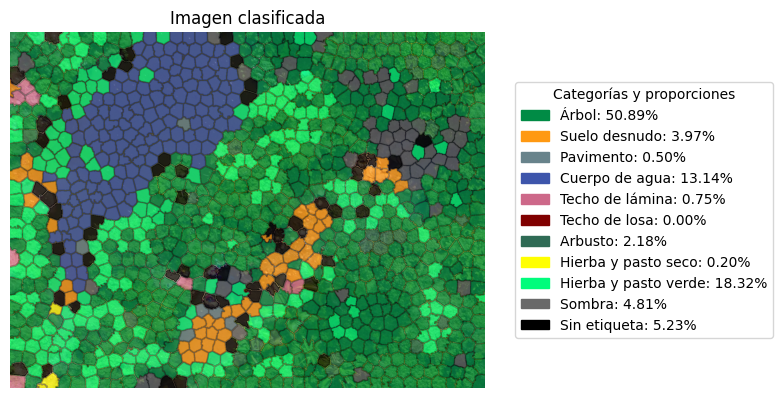

 Imagen pintada exitosamente: image_x5_1730.jpg

 Procesando y pintando imagen: image_x5_250.jpg



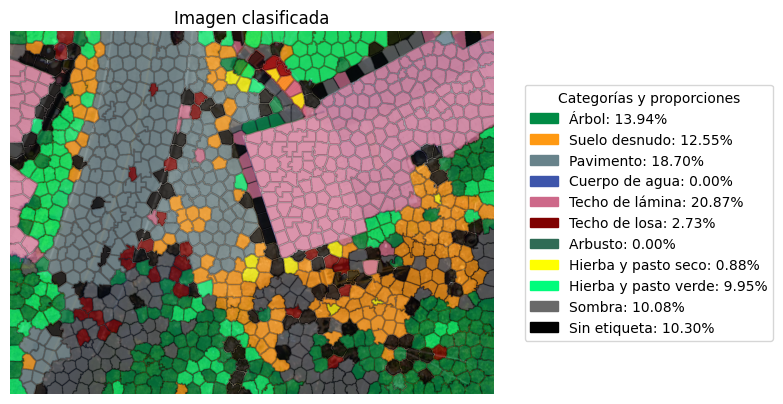

 Imagen pintada exitosamente: image_x5_250.jpg


In [13]:
from funciones_auxiliares_predicciones import img_etiquetas_parallel
import os
import pandas as pd

# Parámetros de segmentación
tamano_superpixeles = 40
ruler = 10
iteraciones = 10
tamano_minimo = 20

# Procesar cada imagen
for imagen in imagenes_jpg:
    print("\n===============================")
    print(f" Procesando y pintando imagen: {imagen}")
    print("===============================\n")
    
    try:
        # Ruta completa a la imagen
        ruta_img = os.path.join(ruta_predicciones_csv, imagen)
        
        # Segmentar imagen
        img_seg, Labels_slic, number_slic = seg_SLIC(
            path_image=ruta_img,
            parametro_1=tamano_superpixeles,
            parametro_2=ruler,
            parametro_3=iteraciones,
            parametro_4=tamano_minimo
        )
        
        # Obtener el nombre base para el CSV
        nombre_base = imagen.replace(".jpg", "")
        nombre_csv = f"Caract_paralelo_{nombre_base}_con_estrategia5.csv"
        ruta_csv = os.path.join(ruta_predicciones_csv, nombre_csv)

        # Cargar el CSV con la columna ya calculada
        df_image_pred = pd.read_csv(ruta_csv)

        # Pintar la imagen con las predicciones ajustadas de estrategia 4
        num_hilos_pintado = 10
        total_time_pintado_parallel, total_time_proporcion = img_etiquetas_parallel(
            df_image_pred["indice"],
            df_image_pred["prediction_actual_estrategia5"],  
            Labels_slic,
            ruta_img,
            img_seg,
            num_threads=num_hilos_pintado
        )
        print(f" Imagen pintada exitosamente: {imagen}")

    except Exception as e:
        print(f" Error procesando {imagen}: {e}")

